In [20]:
%pip install qiskit
%pip install qiskit --upgrade
%pip install 'qiskit[nature]'
%pip install qiskit-aer
%pip install qiskit_algorithms
#%pip install --prefer-binary pyscf # this library can have some issues with pip in macos
%pip install matplotlib 

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 306.9/306.9 kB 6.9 MB/s eta 0:00:00 MB/s eta 0:00:01
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


## Quantum Simulation of the $H_2$ Molecule

### 1. Molecular Hamiltonian:

The Hamiltonian for the $H_2$ molecule comprises the kinetic energy of the electrons, the potential energies due to electron-nuclear interactions, and the electron-electron interactions:

$ \hat{H} = \sum_{i,j} t_{ij} a_i^\dagger a_j + \frac{1}{2} \sum_{i,j,k,l} V_{ijkl} a_i^\dagger a_j^\dagger a_k a_l $

Where:
- $ a_i^\dagger $ and $ a_i $ represent the fermionic creation and annihilation operators, respectively.
- $ t_{ij} $ and $ V_{ijkl} $ are the one-electron and two-electron integrals.

### 2. Mapping to Qubits:

For quantum computations, the fermionic Hamiltonian needs to be translated into a qubit Hamiltonian. The Jordan-Wigner transformation is commonly used, where each fermionic mode corresponds to a qubit:

$ a_j = \frac{1}{2} (X_j + i Y_j) \prod_{k=1}^{j-1} Z_k $

Applying this transformation, the molecular Hamiltonian is expressed as a sum of tensor products of Pauli matrices (X, Y, Z).


In [1]:
import qiskit as qk
from qiskit_nature import settings
from qiskit_nature.second_q.drivers import PySCFDriver
from qiskit_nature.second_q.mappers import JordanWignerMapper, BravyiKitaevMapper
from qiskit_nature.second_q.circuit.library import HartreeFock
from qiskit.circuit.library import TwoLocal
from qiskit.algorithms.optimizers import SPSA
from qiskit.algorithms.minimum_eigensolvers import VQE
from qiskit_aer.primitives import Estimator as AerEstimator

settings.use_pauli_sum_op = False

## Quantum Simulation of $H_2$ Molecule using Qiskit

### 1. **Defining the Molecule**:
- Utilize Qiskit's `PySCFDriver` to define the $H_2$ molecule.
- Specify the atomic coordinates of the two hydrogen atoms and choose an appropriate basis set (e.g., `sto3g`).

### 2. **Hamiltonian Transformation**:
- The electronic structure of the $H_2$ molecule is initially described in terms of fermionic creation and annihilation operators.
- Transform this fermionic Hamiltonian into a qubit (spin) Hamiltonian suitable for quantum computation.
- Two common transformations are:
  - **Jordan-Wigner Transformation**: Provides a direct mapping of fermions to qubits.
    - $ a_j \rightarrow \frac{1}{2} (X_j + i Y_j) \prod_{k=1}^{j-1} Z_k $
    - $ a_j^\dagger \rightarrow \frac{1}{2} (X_j - i Y_j) \prod_{k=1}^{j-1} Z_k $
  - **Bravyi-Kitaev Transformation**: A more efficient mapping especially for systems with local interactions, but is more complex in form.

### 3. **Quantum Algorithms**:
- With the qubit Hamiltonian in hand, employ quantum algorithms like the Variational Quantum Eigensolver (VQE) to estimate the ground state energy of the $H_2$ molecule.


In [2]:
driver = PySCFDriver(atom='H .0 .0 .0; H .0 .0 0.735')# H2 molecule with bond length 0.735 angstrom
problem = driver.run()

/Users/rsnegrin/.pyenv/versions/3.10.1/lib/python3.10/site-packages/pyscf/dft/libxc.py:771: UserWarning: Since PySCF-2.3, B3LYP (and B3P86) are changed to the VWN-RPA variant, corresponding to the original definition by Stephens et al. (issue 1480) and the same as the B3LYP functional in Gaussian. To restore the VWN5 definition, you can put the setting "B3LYP_WITH_VWN5 = True" in pyscf_conf.py
  warnings.warn('Since PySCF-2.3, B3LYP (and B3P86) are changed to the VWN-RPA variant, '


In [3]:
# We can choose mapper here
mapper  = JordanWignerMapper()
# mapper = BravyiKitaevMapper()

In [4]:
# Now we get the second quantized Hamiltonian
hamiltonian = problem.hamiltonian.second_q_op()

# By obtaining this Hamiltonian in the second quantized form, we are then set up to transform it into a qubit representation
qubit_op = mapper.map(hamiltonian)

##### Initial State: Hartree-Fock (HF) State

The **Hartree-Fock (HF) state** serves as a common starting point. It approximates the wavefunction as:

$$
|\psi_{HF}\rangle = \frac{1}{\sqrt{N!}} \sum_{\sigma} (-1)^{\sigma} P_{\sigma} |\phi_1 \phi_2 ... \phi_N \rangle
$$

Where:
- $|\psi_{HF}\rangle$ is the HF wavefunction.
- $N$ is the number of electrons.
- $\sum_{\sigma}$ represents a sum over all possible permutations of the electrons.
- $(-1)^{\sigma}$ is the phase factor for each permutation.
- $P_{\sigma}$ is the permutation operator for permutation $\sigma$.
- $|\phi_1 \phi_2 ... \phi_N \rangle$ is a Slater determinant formed from one-electron wavefunctions (spin-orbitals).

In [5]:
num_particles = (problem.num_alpha,
                 problem.num_beta)
init_state = HartreeFock(problem.num_spin_orbitals, num_particles, mapper)

### 4. **Quantum Simulation**

Now, we will simulate the molecule to obtain its ground state using the **Variational Quantum Eigensolver (VQE)** method.

The **ansatz** prepares quantum states with parameters, $ \theta_k $, which are optimized by VQE:

$$ U(\theta) = e^{-i \theta_k H_k} $$

#### TwoLocal Ansatz

The `TwoLocal` ansatz in Qiskit is a quantum circuit template used for variational algorithms like VQE. It alternates between:
1. Single-qubit rotations: $RY$ gates.
2. Two-qubit entanglements: $CZ$ gates.

This structure provides a balance between expressiveness and computational efficiency, making it a popular choice for approximating quantum states.


In [6]:
ansatz = TwoLocal(rotation_blocks='ry', entanglement_blocks='cz')

### 4. **Optimization Algorithm**

**SPSA** is a popular optimizer used to minimize the expectation value of the energy:

$$ \min_{\theta} \langle \psi(\theta) | H | \psi(\theta) \rangle $$


In [7]:
optimizer = SPSA(maxiter=30)

## Start the Simulation

Now that we've set up the problem, let's define the quantum backend and proceed with the actual simulation.


In [8]:
backend = qk.Aer.get_backend('statevector_simulator')

In [9]:
# Setting up the VQE Algorithm
# another option
aer_estimator = AerEstimator(run_options={"shots": 2048, "seed": 42})
qe_program = VQE(aer_estimator, ansatz,optimizer)

In [10]:
result = qe_program.compute_minimum_eigenvalue(operator=qubit_op)

In [11]:
print(f"Ground state energy: {result.eigenvalue.real} Ha")

Ground state energy: -1.6902070552404864 Ha


For the $H_2$ molecule at a bond length of approximately $0.735$ angstroms, the ground state energy is approximately $-1.174$ Hartree [source](https://irinsubria.uninsubria.it/bitstream/11383/1715315/1/JCP_H2_1sigma_g.pdf).



# Evolution of the $H_2$ Molecule

Now, we will use **trotterization** to see how the $H_2$ molecule evolves.


In [51]:
from qiskit.primitives import Estimator
from qiskit.algorithms.time_evolvers import TimeEvolutionProblem, TrotterQRTE
from qiskit.quantum_info import Statevector

final_time = 1.6

# Create the initial state
statevector = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0]

# Create the quantum circuit
initial_state = qk.QuantumCircuit(4)
initial_state.initialize(statevector, [0,1,2,3])

evolution_problem = TimeEvolutionProblem(qubit_op, initial_state=initial_state, time=final_time)

In [52]:
trotter = TrotterQRTE()
estimator = Estimator()
trotter_qrte = TrotterQRTE(estimator=estimator)
evolved_state = trotter_qrte.evolve(evolution_problem)

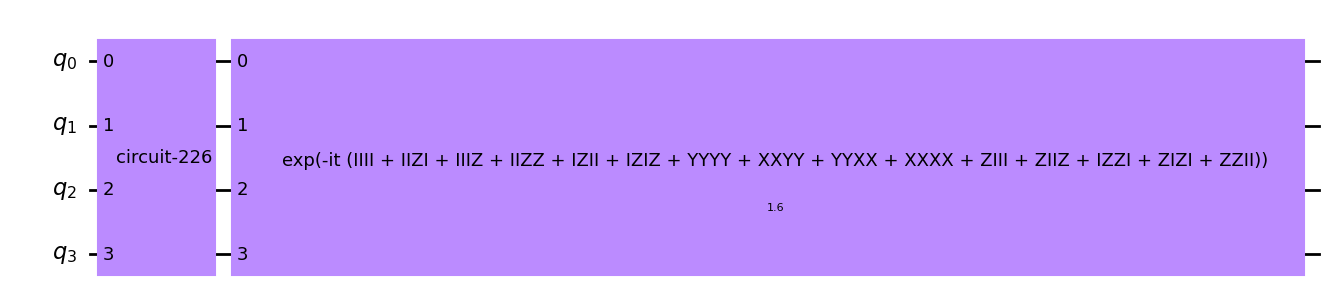

In [58]:
evolved_state.evolved_state.draw('mpl')

In [57]:
statevector = Statevector(evolved_state.evolved_state)

In [59]:
statevector

Statevector([ 2.44003311e-18-7.96192330e-18j,
             -1.49894788e-17+6.54940524e-19j,
             -2.20979691e-17+2.11183173e-17j,
             -1.78349856e-18+6.14084450e-18j,
              7.96958676e-18+1.89605040e-17j,
              2.56290563e-01-1.25715964e-01j,
             -3.83971021e-17+8.57930228e-18j,
             -4.53631204e-18-2.35204963e-17j,
             -3.73488769e-18+1.37924142e-17j,
              1.19741128e-16-6.05296440e-17j,
              8.85564788e-01+3.66450064e-01j,
              7.16456151e-17+8.54951022e-17j,
              1.89172146e-17-1.74305213e-17j,
             -1.00521582e-16+2.62758295e-17j,
              5.00592876e-18-2.04568686e-17j,
              1.51383605e-17-5.11186429e-17j],
            dims=(2, 2, 2, 2))
